# Laboratorio 3 - Deep Learning / Redes Neuronales

### Sebastian Juárez 21471

## Analisis Exploratorio

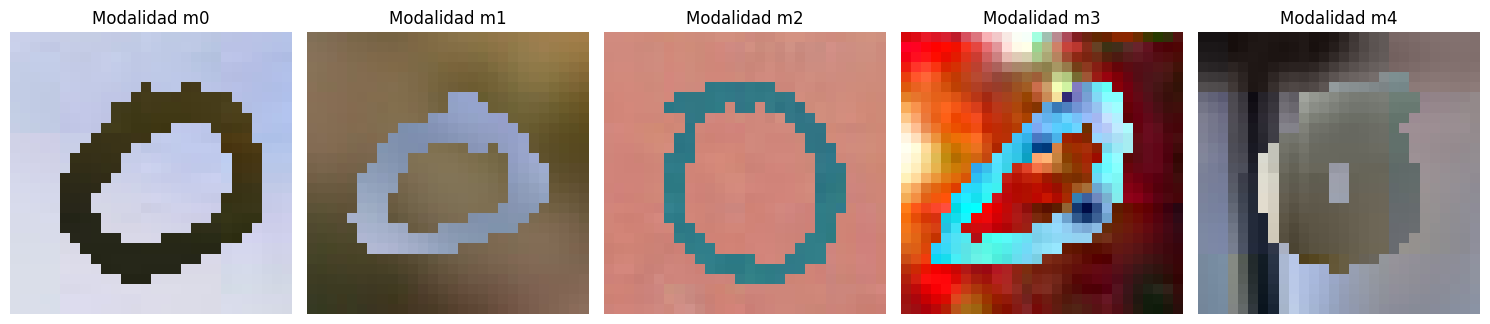

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

base_path = "Data/Poly/PolyMNIST/MMNIST/train"

modalidades = ["m0", "m1", "m2", "m3", "m4"]

fig, axs = plt.subplots(1, 5, figsize=(15, 4))

for i, modalidad in enumerate(modalidades):
    img_path = os.path.join(base_path, modalidad, "0.0.png")
    img = Image.open(img_path)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"Modalidad {modalidad}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image
import pandas as pd

conteo = {"modalidad": [], "train_imgs": [], "test_imgs": [], "resolucion": []}

for modalidad in modalidades:
    train_dir = os.path.join(base_path, "train", modalidad)
    test_dir = os.path.join(base_path, "test", modalidad)

    train_imgs = os.listdir(train_dir)
    test_imgs = os.listdir(test_dir)

    # Tomar una imagen para verificar resolución
    sample_img = Image.open(os.path.join(train_dir, train_imgs[0]))
    resolucion = sample_img.size  # (ancho, alto)

    conteo["modalidad"].append(modalidad)
    conteo["train_imgs"].append(len(train_imgs))
    conteo["test_imgs"].append(len(test_imgs))
    conteo["resolucion"].append(f"{resolucion[0]}x{resolucion[1]}")

df_conteo = pd.DataFrame(conteo)
print(df_conteo)


  modalidad  train_imgs  test_imgs resolucion
0        m0       60000      10000      28x28
1        m1       60000      10000      28x28
2        m2       60000      10000      28x28
3        m3       60000      10000      28x28
4        m4       60000      10000      28x28


## Division de imagenes

In [18]:
from torch.utils.data import Dataset
from PIL import Image
import os

class PolyMNISTDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.img_names = [f for f in os.listdir(folder_path) if f.endswith(".png")]
        self.transform = transform

        # Filtrar solo imágenes con etiquetas válidas (0 a 9)
        self.img_names = [f for f in self.img_names if self._get_label(f) in range(10)]

    def _get_label(self, fname):
        # fname = "1609.4.png" → split = ["1609", "4", "png"]
        return int(fname.split('.')[1])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        label = self._get_label(img_name)
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, label



In [19]:
import torchvision.transforms as transforms

# Transformaciones para entrenamiento con augmentations
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

# Transformaciones para prueba sin augmentations
transform_test = transforms.Compose([
    transforms.ToTensor()
])


In [20]:
# Seleccionamos una modalidad, por ejemplo "m0"
modalidad = "m0"
train_path = f"Data/Poly/PolyMNIST/MMNIST/train/{modalidad}"
test_path  = f"Data/Poly/PolyMNIST/MMNIST/test/{modalidad}"

# Instanciar datasets
train_dataset = PolyMNISTDataset(train_path, transform=transform_train)
test_dataset  = PolyMNISTDataset(test_path, transform=transform_test)


In [21]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Modelo CNN

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1   = nn.Linear(64 * 7 * 7, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # -> [64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [23]:
import torch
from torch import optim

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# Instanciar modelo, pérdida y optimizador
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
def entrenar_modelo(model, train_loader, test_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = correct / total * 100
        print(f"Época {epoch+1}: pérdida = {running_loss:.4f}, accuracy = {acc:.2f}%")

    print("Entrenamiento completo.")


Usando: cpu


In [24]:
def evaluar_modelo(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Accuracy en test: {accuracy:.2f}%")


In [25]:
entrenar_modelo(model, train_loader, test_loader, epochs=5)
evaluar_modelo(model, test_loader)


Época 1: pérdida = 979.9760, accuracy = 64.84%
Época 2: pérdida = 540.7263, accuracy = 81.40%
Época 3: pérdida = 421.5934, accuracy = 85.57%
Época 4: pérdida = 350.1723, accuracy = 88.04%
Época 5: pérdida = 301.4448, accuracy = 89.74%
Entrenamiento completo.
Accuracy en test: 94.66%


## Red Neuronal Simple

In [26]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [27]:
model = SimpleNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

entrenar_modelo(model, train_loader, test_loader, epochs=5)
evaluar_modelo(model, test_loader)


KeyboardInterrupt: 